In [1]:
#Compiler Version
!python --version 

Python 3.7.14


In [6]:
#Question 2a

#Importing required libraries
import numpy as np
from matplotlib import pyplot as plt
import random

#Number of games required for training against each opponent
train_num_games = 10000

#Number of games after which we have to test the trained agent
num_test_trained_agent = 200

#Number of games performed for testing
num_test_games = 100

#Final number of testing games
test_games = 1000

#Tic-Tac-Toe game environment
class Tic_Tac_Toe(object):

    def __init__(self, n):
        self.n = n
        self.board = np.zeros((n, n))
        self.is_end = False
    
    #Initializing the environment and deciding who makes the first move
    def init(self):
        self.board = np.zeros((self.n, self.n))
        self.is_end = False
        self.next_reward = 0
        return random.choice([1,-1])
    
    #Act method
    def act(self, position, symbol):
        self.board[position] = symbol

    #Returns empty board positions
    def actions(self):
        positions = []
        for i in range(self.n):
            for j in range(self.n):
                if self.board[i, j] == 0:
                    positions.append((i, j))
        return positions

    #Check if there is a winner in the board
    def winner(self):
        #Check if any of rows are all equal
        for i in range(self.n):
            row_sum = sum(self.board[i, :])
            if row_sum == self.n:
                self.is_end = True
                return 1
            if row_sum == -self.n:
                self.is_end = True
                return -1
        
        #Check if any of columns are all equal
        for i in range(self.n):
            col_sum = sum(self.board[:, i])
            if col_sum == self.n:
                self.is_end = True
                return 1
            if col_sum == -self.n:
                self.is_end = True
                return -1
        
        #Check if any of diagonal are all equal
        diag_sum1 = sum([self.board[i, i] for i in range(self.n)])
        diag_sum2 = sum([self.board[i, self.n - i -1] for i in range(self.n)])
        if diag_sum1 == self.n or diag_sum2 == self.n:
            self.is_end = True
            return 1
        if diag_sum1 == -self.n or diag_sum2 == -self.n:
            self.is_end = True
            return -1

        #If there are no positions left
        if len(self.actions()) == 0:
            self.is_end = True
            return 0
        
        #If there are empty spaces left to play
        self.is_end = False
        return None

    #Return reward for the present state
    def reward(self):
        result = self.winner()
        if result == 1:
            return 5
        if result == -1:
            return -5
        if result == 0:
            return 1
        return 0

    #Return state of board as a sring
    def state(self):
        return str(self.board.reshape(self.n*self.n))

In [7]:
#Question 2b

#Random Agent
class Random_Agent(object):

    def __init__(self):
        pass

    #Policy for random agent
    def policy(self, environment):
        #Find the available actions
        actions = environment.actions()
        #Return a random action
        return random.choice(actions)

#Safe Agent
class Safe_Agent(object):

    def __init__(self):
        pass
    
    #Policy for safe agent
    def policy(self, environment):
        #Find the available actions
        actions = environment.actions()
        #Check if there is a possibility of win in any row
        for i in range(environment.n):
            row_sum = sum(environment.board[i, :])
            if row_sum == 1 - environment.n:
                return (i, list(environment.board[i, :]).index(0))

        #Check if there is a possibility of win in any column
        for i in range(environment.n):
            col_sum = sum(environment.board[:, i])
            if col_sum == 1 - environment.n:
                return (list(environment.board[:, i]).index(0), i)

        #Check if there is a possiblity of win in any diagonal
        diag_1 = [environment.board[i, i] for i in range(environment.n)]
        diag_2 = [environment.board[i, environment.n - i -1] for i in range(environment.n)]
        
        if sum(diag_1) == 1 - environment.n:
            return (diag_1.index(0), diag_1.index(0))

        if sum(diag_2) == 1 - environment.n:
            return (diag_2.index(0), environment.n - 1 - diag_2.index(0))

        #Check if there is a possibility of block in any row
        for i in range(environment.n):
            row_sum = sum(environment.board[i, :])
            if row_sum == environment.n - 1:
                return (i, list(environment.board[i, :]).index(0))

        #Check if there is a possibility of block in any column
        for i in range(environment.n):
            col_sum = sum(environment.board[:, i])
            if col_sum == environment.n - 1:
                return (list(environment.board[:, i]).index(0), i)

        #Check if there is a possiblity of block in any diagonal
        diag_1 = [environment.board[i, i] for i in range(environment.n)]
        diag_2 = [environment.board[i, environment.n - i -1] for i in range(environment.n)]
        
        if sum(diag_1) == environment.n - 1:
            return (diag_1.index(0), diag_1.index(0))

        if sum(diag_2) == environment.n - 1:
            return (diag_2.index(0), environment.n - 1 - diag_2.index(0))

        #If there is no winning or blocking moves
        return random.choice(actions)

#Q-learning Agent
class Qlearn_Agent(object):

    def __init__(self):
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = 0.05
        self.Q_table = {}
    
    #Choose the action to try in this state
    def choose(self, environment):
        #Find actions that can be performed
        actions = environment.actions()
        #Choose the type of exploration
        p = random.random()
        #Random round
        if p < self.epsilon:
            return random.choice(actions)
        else:
            return self.policy(environment, actions)

    #Policy for chosing best action
    def policy(self, environment, actions):
        #Extract state from environment
        s = environment.state()
        #Select the best action for the state
        max_value = max([self.Q(s, a) for a in actions])
        max_actions = [a for a in actions if self.Q(s,a) == max_value]
        return random.choice(max_actions)

    #Extract Q(s,a) value from Q table
    def Q(self, s, a):
        if (s, a) in self.Q_table:
            return self.Q_table[(s, a)]
        self.Q_table[(s, a)] = 0
        return self.Q_table[(s, a)]
        
    #Observe the environment
    def observe(self, environment, state_before_agent, action_performed, state_after_agent):
        #Find actions of the environment
        actions = environment.actions()

        #Reward of present state
        reward = environment.reward()

        #Update the Q table
        if len(actions) == 0:
            max_value = 0
        else:
            max_value = max([self.Q(state_after_agent, a) for a in actions])
        self.Q_table[(state_before_agent, action_performed)] = self.Q(state_before_agent, action_performed) + self.alpha*(reward + self.gamma*max_value - self.Q(state_before_agent, action_performed))

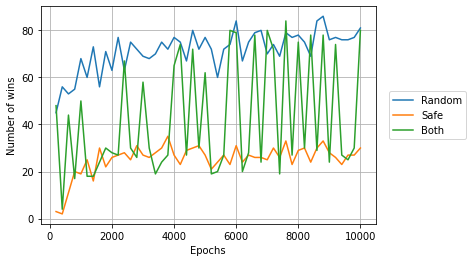

Agent trained against Random opponent vs Random opponent
Wins 750 Loses 71 Draws 179
Agent trained against Random opponent vs Safe opponent
Wins 89 Loses 325 Draws 586
Agent trained against Safe opponent vs Random opponent
Wins 574 Loses 186 Draws 240
Agent trained against Safe opponent vs Safe opponent
Wins 287 Loses 93 Draws 620
Agent trained against Both opponent vs Random opponent
Wins 798 Loses 48 Draws 154
Agent trained against Both opponent vs Safe opponent
Wins 277 Loses 124 Draws 599


In [8]:
#Question 2c

#Function for playing opponent turn
def play_opponent_turn(environment, opponent):
    #Choose the appropriate action using the opponent policy
    appropriate_action = opponent.policy(environment)

    #Perform the above choosen action
    environment.act(appropriate_action, -1)

    #Return the action performed
    return environment, appropriate_action

#Function for playing agent turn
def play_agent_turn(environment, agent):
    #Choose the best move by the agent
    appropriate_action = agent.choose(environment)

    #Perform the above chosen action
    environment.act(appropriate_action, 1)

    #Return the action performed
    return environment, appropriate_action

#Program to test the agent against opponents
def test(environment, agent, opponent, num_rounds = num_test_games, print_results = False):
    rewards = []
    for game_num in range(num_rounds):
        #Initialise the environment for this game and choose who makes the first move using fair toss
        turn = environment.init()

        #If the first turn is opponent's
        if turn == -1:
            environment, opponent_action_performed = play_opponent_turn(environment, opponent)
        
        #Recursively play agent turn and opponent turn until game ends
        while not environment.is_end:
            #Play the agent turn
            environment, agent_action_performed = play_agent_turn(environment, agent)

            #Check the winner
            winner = environment.winner()

            #If the winner is not yet decided
            if winner is None:
                #Play the opponent turn
                environment, opponent_action_performed = play_opponent_turn(environment, opponent)

            #Collect the reward after each turn
            reward = environment.reward()
        #Store the reward after each game
        rewards.append(reward)

    #Record the stats for the number of games    
    if print_results:
        print('Wins', rewards.count(5),'Loses', rewards.count(-5), 'Draws', rewards.count(1))
    else:   
        return rewards.count(5) #Return the number of wins

#Program to train the agent against opponents
def train(environment, agent, opponents):
    train_wins = []
    #Train with train_num_games initialised globally
    for game_num in range(1,train_num_games+1):
        #Choose one of the opponent for this game
        opponent = random.choice(opponents)
        #Initialise the environment for this game and choose who makes the first move using fair toss
        turn = environment.init()

        #If the first turn is opponent's
        if turn == -1:
            environment, opponent_action_performed = play_opponent_turn(environment, opponent)
        
        #Recursively play agent turn and opponent turn until game ends
        while not environment.is_end:
            #State before agent turn
            state_before_agent = environment.state()

            #Play the agent turn
            environment, agent_action_performed = play_agent_turn(environment, agent)

            #State after agent turn
            state_after_agent = environment.state()

            #Check the winner
            winner = environment.winner()

            #If the winner is not yet decided
            if winner is None:
                #Play the opponent turn
                environment, opponent_action_performed = play_opponent_turn(environment, opponent)

                #State after this turn
                state_after_agent = environment.state()
            
            #Observe the environment after this move
            agent.observe(environment, state_before_agent, agent_action_performed, state_after_agent)

        #After every num_test_trained_agent games assess the efficacy of the learning
        if game_num % num_test_trained_agent == 0:
            num_wins = test(environment, agent, opponent)
            train_wins.append(num_wins)

    #Return the trained agent
    return agent, train_wins

#Create environment 
environment = Tic_Tac_Toe(3)

#Train against random player
random_opponent = Random_Agent()
random_agent = Qlearn_Agent()
random_agent, random_agent_train_wins = train(environment, random_agent, [random_opponent])

#Train against Safe player
safe_opponent = Safe_Agent()
safe_agent = Qlearn_Agent()
safe_agent, safe_agent_train_wins = train(environment, safe_agent, [safe_opponent])

#Train with randomly selected opponent
both_agent = Qlearn_Agent()
both_agent, both_agent_train_wins = train(environment, both_agent,[random_opponent, safe_opponent])

#Plotting
epochs = np.arange(num_test_trained_agent,train_num_games + num_test_trained_agent,num_test_trained_agent)
plt.plot(epochs,random_agent_train_wins,label = "Random")
plt.plot(epochs,safe_agent_train_wins,label = "Safe")
plt.plot(epochs,both_agent_train_wins,label = "Both")
plt.xlabel("Epochs")
plt.ylabel("Number of wins")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.grid()
plt.show()

#Testing

# Random Trained vs Random player
print("Agent trained against Random opponent vs Random opponent")
test(environment, random_agent, random_opponent, test_games, print_results=True)

# Random Trained vs Safe Player
print("Agent trained against Random opponent vs Safe opponent")
test(environment, random_agent, safe_opponent, test_games, print_results=True)

# Safe Trained vs Random Player
print("Agent trained against Safe opponent vs Random opponent")
test(environment, safe_agent, random_opponent, test_games, print_results=True)

# Safe Trained vs Safe Player
print("Agent trained against Safe opponent vs Safe opponent")
test(environment, safe_agent, safe_opponent, test_games, print_results=True)

# Both Trained vs Random Player
print("Agent trained against Both opponent vs Random opponent")
test(environment, both_agent, random_opponent, test_games, print_results=True)

# Both Trained vs Safe Player
print("Agent trained against Both opponent vs Safe opponent")
test(environment, both_agent, safe_opponent, test_games, print_results=True)

Question 2c

4) Among the above three trained agents, we can see that the third agent (the one 
which which is trained against both Random and Safe opponents) gives the best 
performance while testing against Random and Safe opponents. This is beacause it is trained against all possible random and safe moves making it more robust.

5) The Q-learning agent developed above is **not** unbeatable by any possible opponent. But it is possible to make the agent more robust in the following ways : 
- Improve the training process by optimizing the hyperparameters.
- Increase the number of training epochs (or) iterations.
- Make the Q-learning agent play against itself.